# Instructions to run the Code in the google collab

Install the following libraries

1.   Unidecode
2.   word2number
3.   contractions
4.   pandas
5.   nltk

Load the train.txt and the val.txt data into the google colab workspace.

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

!pip install Unidecode
!pip install word2number
!pip install contractions


import collections
import math
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import urllib.request
import contractions
# import re
# import string
import unidecode
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
# import gensim.downloader as api
from word2number import w2n
import matplotlib.pyplot as plt
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
wnl = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Preprocessing of Training and Validation Data

In [26]:
def preprocessing_data(data,data_val,stop_words_removal,lemmatization):

  #Expanding contractions
  data = contractions.fix(data)
  data_val = contractions.fix(data_val)

  # word to numbers
  # data = w2n.word_to_num(data)
  # data_val = w2n.word_to_num(data_val)

  # Tokenize after expanding contractions instead of just splitting with space
  data = word_tokenize(data)
  data_val = word_tokenize(data_val)

  # Stop word and puntuaction marks removal
  if stop_words_removal:
    data = [word for word in data if word.lower() not in stop_words and word not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and word[0] not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
    data_val = [word for word in data_val if word.lower() not in stop_words and word not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and word[0] not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
  else:
    data = [word for word in data if word not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and word[0] not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
    data_val = [word for word in data_val if word not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and word[0] not in '#!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']

  # Lemmatization, Case folding
  for i in range(len(data)):
      # data[i] = stemmer.stem(data[i])
      data[i] = data[i].lower()
      if lemmatization:
        data[i] = wnl.lemmatize(data[i])

  for i in range(len(data_val)):
      # data_val[i] = stemmer.stem(data_val[i])
      data_val[i] = data_val[i].lower()
      if lemmatization:
        data_val[i] = wnl.lemmatize(data_val[i])

  return data, data_val

# Unknown Word Handling

In [27]:
def unknown_word_handling(data,unknown_word):
  data_new = []
  counts = Counter(data)
  counts = sorted(counts.items(), key=lambda x: x[1])
  least_count_words = []
  for word in counts:
    if int(word[1]) == 1:
      least_count_words.append(word[0])

  for idx,word in enumerate(data):
    if word in least_count_words:
      data_new.append(unknown_word)
    else:
      data_new.append(word)

  return data_new


# Unigram models to calculate probabilities with and without smoothing

In [28]:
def unigram_model(data,data_val,list_k,unknown_word):
  def get_probabilities_unigram(unigram_counter):
    unigram_probabilities = {}
    total_unigrams = sum(unigram_counter.values())
    for word, count in unigram_counter.items():
        unigram_probabilities[word] = count/total_unigrams

    return unigram_probabilities

  def get_probabilities_unigram_laplace_smoothing(unigram_counter,k,unknown_word):
    unigram_probabilities = {}
    total_unigrams = sum(unigram_counter.values())
    for word, count in unigram_counter.items():
        unigram_probabilities[word] = (count+1)/(total_unigrams + len(unigram_counter))

    return unigram_probabilities

  def get_probabilities_unigram_k_smoothing(unigram_counter,k,unknown_word):
    unigram_probabilities = {}
    total_unigrams = sum(unigram_counter.values())
    for word, count in unigram_counter.items():
        unigram_probabilities[word] = (count+k)/(total_unigrams + len(unigram_counter)*k)

    return unigram_probabilities


  def get_perplexity_unigram(data_1,probabilities,word_count,unknown_word):
    perplexity = 0
    for word in data_1:
      if word in word_count.keys():
        perplexity += (-1)*np.log(probabilities[word])
      else:
        perplexity += (-1)*np.log(probabilities[unknown_word])

    perplexity = (1/len(data_1))*perplexity
    perplexity = np.exp(perplexity)
    return perplexity


  unigram_counter = {}
  unigram_probabilities = {}

  for i in range(len(data)):
    if data[i] in unigram_counter:
      unigram_counter[data[i]] += 1
    else:
      unigram_counter[data[i]] = 1

  print(len(data), len(unigram_counter), unigram_counter['unk'])
  results = []

  unigram_probabilities = get_probabilities_unigram(unigram_counter)
  perplexity_unigram_un = get_perplexity_unigram(data_val,unigram_probabilities,unigram_counter,unknown_word)
  perplexity_unigram_un1 = get_perplexity_unigram(data,unigram_probabilities,unigram_counter,unknown_word)
  results.append(perplexity_unigram_un)
  results.append(perplexity_unigram_un1)

  # laplace smoothing
  unigram_probabilities1 = get_probabilities_unigram_laplace_smoothing(unigram_counter,1,unknown_word)
  perplexity_unigram1 = get_perplexity_unigram(data_val,unigram_probabilities1,unigram_counter,unknown_word)
  perplexity_unigram2 = get_perplexity_unigram(data,unigram_probabilities1,unigram_counter,unknown_word)
  results.append(perplexity_unigram1)
  results.append(perplexity_unigram2)

  # smoothing with various k
  unigram_prob_dict = {}
  unigram_prob_dict1 = {}
  for k in list_k:
    unigram_probabilities = get_probabilities_unigram_k_smoothing(unigram_counter,k,unknown_word)
    perplexity_unigram = get_perplexity_unigram(data_val,unigram_probabilities,unigram_counter,unknown_word)
    unigram_prob_dict[k] = perplexity_unigram
    perplexity_unigram_1 = get_perplexity_unigram(data,unigram_probabilities,unigram_counter,unknown_word)
    unigram_prob_dict1[k] = perplexity_unigram_1
  results.append(unigram_prob_dict)
  results.append(unigram_prob_dict1)

  return results



# Bigram models to calculate probabilities with and without smoothing

In [29]:
def bigram_model(data,data_val,list_k,unknown_word):
  def get_probabilities_bigram(unigram_counter,bigram_counter):
    bigram_probabilities = {}
    for (word1, word2), count in bigram_counter.items():
      bigram_probabilities[(word1, word2)] = count / unigram_counter[word1]

    return bigram_probabilities

  def get_probabilities_bigram_laplace_smoothing(unigram_counter,bigram_counter,k):
      bigram_probabilities = {}
      for (word1, word2), count in bigram_counter.items():
        bigram_probabilities[(word1, word2)] = (count +1) / (unigram_counter[word1] + len(unigram_counter))

      return bigram_probabilities


  def get_probabilities_bigram_k_smoothing(unigram_counter,bigram_counter,k):
      bigram_probabilities = {}
      for (word1, word2), count in bigram_counter.items():
        bigram_probabilities[(word1, word2)] = (count +k) / (unigram_counter[word1] + (len(unigram_counter)*k))

      return bigram_probabilities


  def get_unigram_probability(unigram_counter,k,unknown_word):
    unigram_probabilities = {}
    total_unigrams = sum(unigram_counter.values())
    for word, count in unigram_counter.items():
        unigram_probabilities[word] = (count)/(total_unigrams)

    return unigram_probabilities


  def get_perplexity_bigram(data_1,probabilities,word_count,unknown_word,unigram_counter,unigram_probabilities,k,lambda_val):
      perplexity = 0
      for i in range(len(data_1)):
        if i < len(data_1) - 1:
            if (data_1[i], data_1[i + 1]) in word_count:
              perplexity += (-1)*np.log(probabilities[(data_1[i], data_1[i + 1])])
            elif 0<k<10:  # laplace and add-K smoothing
              perplexity += (-1)*math.log((k)/ (unigram_counter[data_1[i]] + (len(unigram_counter))*k))
            elif k==100:  # Stupid backoff
              perplexity += (-1)*math.log(lambda_val * unigram_probabilities[data[i+1]])
            else:  # unsmoothed
              perplexity += (-1)*np.log(0)
      perplexity = np.exp(perplexity/len(data_1))
      return perplexity


  bigram_counter = {}
  bigram_probabilities = {}
  unigram_counter = {}

  for i in range(len(data)):
    if data[i] in unigram_counter:
      unigram_counter[data[i]] += 1
    else:
      unigram_counter[data[i]] = 1

  unigram_probabilities = get_unigram_probability(unigram_counter,0,unknown_word)

  for i in range(len(data)):
      if i < len(data) - 1:
          if (data[i], data[i + 1]) in bigram_counter:
            bigram_counter[(data[i], data[i + 1])] += 1
          else:
            bigram_counter[(data[i], data[i + 1])] = 1

  results = []
  bigram_probabilities = get_probabilities_bigram(unigram_counter,bigram_counter)
  perplexity_bigram_un = get_perplexity_bigram(data_val,bigram_probabilities,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,0,0)
  perplexity_bigram_un_1 = get_perplexity_bigram(data,bigram_probabilities,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,0,0)
  results.append(perplexity_bigram_un)
  results.append(perplexity_bigram_un_1)

  # laplace smoothing
  bigram_probabilities1 = get_probabilities_bigram_laplace_smoothing(unigram_counter,bigram_counter,1)
  perplexity_bigram1 = get_perplexity_bigram(data_val,bigram_probabilities1,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,1,0)
  perplexity_bigram2 = get_perplexity_bigram(data,bigram_probabilities1,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,1,0)
  results.append(perplexity_bigram1)
  results.append(perplexity_bigram2)

  # smoothing with various k
  bigram_prob_dict = {}
  bigram_prob_dict_1 = {}
  for k in list_k:
    bigram_probabilities = get_probabilities_bigram_k_smoothing(unigram_counter,bigram_counter,k)
    perplexity_bigram = get_perplexity_bigram(data_val,bigram_probabilities,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,k,0)
    bigram_prob_dict[k] = perplexity_bigram
    perplexity_bigram_1 = get_perplexity_bigram(data,bigram_probabilities,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,k,0)
    bigram_prob_dict_1[k] = perplexity_bigram_1
  results.append(bigram_prob_dict)
  results.append(bigram_prob_dict_1)


  # backoff
  bigram_prob_dict1 = {}
  bigram_prob_dict2 = {}
  for lambd in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    bigram_probabilities2 = get_probabilities_bigram(unigram_counter,bigram_counter)
    perplexity_bigram2 = get_perplexity_bigram(data_val,bigram_probabilities2,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,100,lambd)
    bigram_prob_dict1[lambd] = perplexity_bigram2
    perplexity_bigram_2 = get_perplexity_bigram(data,bigram_probabilities2,bigram_counter,unknown_word,unigram_counter,unigram_probabilities,100,lambd)
    bigram_prob_dict2[lambd] = perplexity_bigram_2
  results.append(bigram_prob_dict1)
  results.append(bigram_prob_dict2)


  return results


In [30]:
def plot_graphs(perplexity_dict,title):
  x = perplexity_dict.keys()
  y = []
  for key in perplexity_dict:
    y.append(perplexity_dict[key])

  plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
          marker='o', markerfacecolor='blue', markersize=12)
  # plt.ylim(1,8)
  # plt.xlim(1,8)
  plt.xlabel('K value')
  plt.ylabel('Perplexity')
  plt.title(title)
  plt.show()



# Main Function

79094 2854 2844


<ipython-input-29-9a20430ae367>:45: RuntimeWarning: divide by zero encountered in log
  perplexity += (-1)*np.log(0)


 Unigram Model

Train data
perplexity without smoothing Train data-   358.47073878843906
perplexity with laplace smoothing Train data-   359.5425233116169
perplexity with add-k smoothing with different values of k Train data
  3   -   365.2885976125133
  2   -   362.0146929806651
  0.8   -   359.18737976571157
  0.5   -   358.7710905812511
  0.4   -   358.6678094076761
  0.3   -   358.58447673150624
  0.2   -   358.52264988633397
  0.1   -   358.4840784427698
  0.05   -   358.47412114994734
  0.01   -   358.47087564645085
  0.005   -   358.47077305182626
  0.001   -   358.47074016019263




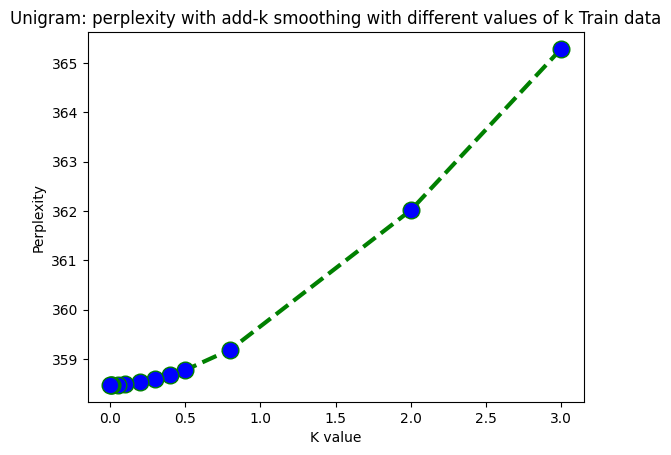


 Test data
perplexity without smoothing Test data-   316.63300318380203
perplexity with laplace smoothing Test data-   319.17159248247077
perplexity with add-k smoothing with different values of k Test data 
  3   -   326.56631723855173
  2   -   322.6109908791357
  0.8   -   318.5734776427298
  0.5   -   317.7512026328851
  0.4   -   317.4998993617732
  0.3   -   317.26138595722057
  0.2   -   317.03664319042366
  0.1   -   316.8267697763078
  0.05   -   316.7277896999504
  0.01   -   316.65161650291077
  0.005   -   316.6422880705437
  0.001   -   316.63485666860987




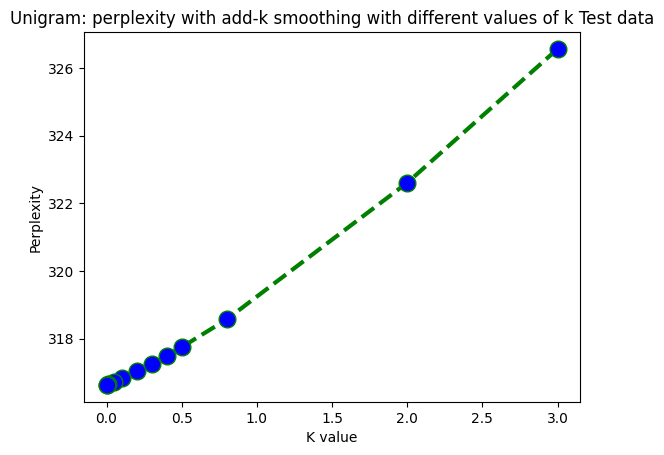




 Bigram Model

Train data
perplexity without smoothing Train data -   34.65214624074505
perplexity with laplace smoothing Train data-   422.2375591663779
perplexity with add-k smoothing with different values of k Train data 
  3   -   771.9821509734941
  2   -   623.9802841185887
  0.8   -   370.72235997508875
  0.5   -   281.40385442987343
  0.4   -   247.12689068422915
  0.3   -   209.57592375472854
  0.2   -   167.4257389477028
  0.1   -   117.50339834545316
  0.05   -   86.43334749040528
  0.01   -   51.767309574223844
  0.005   -   45.02275369708487
  0.001   -   37.54492005998284




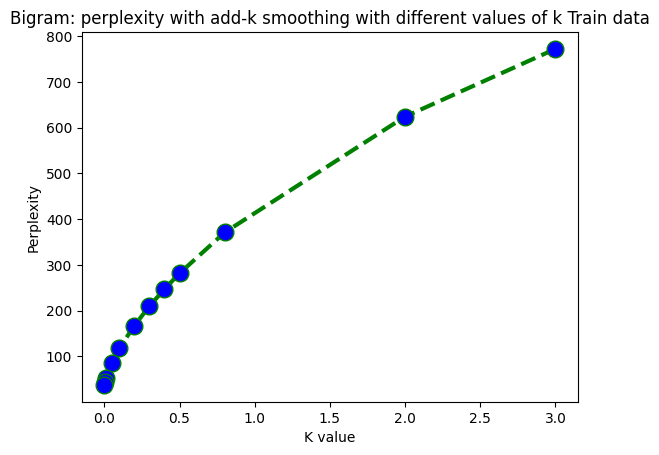

perplexity with back off with different values of lambda Train data
  0.1   -   34.65214624074505
  0.2   -   34.65214624074505
  0.3   -   34.65214624074505
  0.4   -   34.65214624074505
  0.5   -   34.65214624074505
  0.6   -   34.65214624074505
  0.7   -   34.65214624074505
  0.8   -   34.65214624074505
  0.9   -   34.65214624074505



Test data
perplexity without smoothing Test data -   inf
perplexity with laplace smoothing Test data -   504.8563277590332
perplexity with add-k smoothing with different values of k Test data 
  3   -   817.4737453254293
  2   -   684.6573755155939
  0.8   -   458.8767655475942
  0.5   -   378.61946594709275
  0.4   -   347.50943224730054
  0.3   -   313.1425780952058
  0.2   -   274.1700993445572
  0.1   -   227.8425206106818
  0.05   -   200.44642775712856
  0.01   -   185.04508139964972
  0.005   -   194.28608263854412
  0.001   -   249.60895675904322




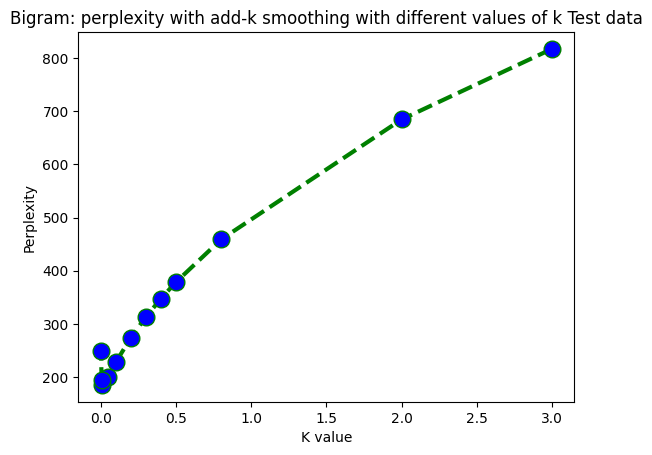

perplexity with back off with different values of lambda Test data
  0.1   -   114.97339849580963
  0.2   -   96.22127658721995
  0.3   -   86.70380468523848
  0.4   -   80.52761933806775
  0.5   -   76.04162101477304
  0.6   -   72.56244384292646
  0.7   -   69.74532912567655
  0.8   -   67.39359221012145
  0.9   -   65.38512251744874




In [31]:
list_k = [3,2,0.8,0.5,0.4,0.3,0.2,0.1,0.05,0.01,0.005,0.001]
stop_words_removal = False
lemmatization = True
unknown_word = "unk"
# lambda_val = 0.4

with open('train.txt', 'r', encoding='utf-8') as file:
    data = file.read()

with open('val.txt', 'r', encoding='utf-8') as file:
    data_val = file.read()

# Preprocessing
data, data_val = preprocessing_data(data,data_val,stop_words_removal,lemmatization)

#Unknowing word handling
data_new = unknown_word_handling(data,unknown_word)

unigram_counter = {}

for i in range(len(data_new)):
  if data_new[i] in unigram_counter:
    unigram_counter[data_new[i]] += 1
  else:
    unigram_counter[data_new[i]] = 1

data_val_new = []
for word in data_val:
  if word in unigram_counter.keys():
    data_val_new.append(word)
  else:
    data_val_new.append(unknown_word)

results_unigram = unigram_model(data_new,data_val_new,list_k,unknown_word)
results_bigram = bigram_model(data_new,data_val_new,list_k,unknown_word)

print(" Unigram Model\n")
print("Train data")
print("perplexity without smoothing Train data-  ",results_unigram[1])
print("perplexity with laplace smoothing Train data-  ",results_unigram[3])

print("perplexity with add-k smoothing with different values of k Train data")
for key in results_unigram[5]:
  print(" ",key,"  -  ",results_unigram[5][key])
print("\n")
plot_graphs(results_unigram[5],"Unigram: perplexity with add-k smoothing with different values of k Train data")


print("\n Test data")
print("perplexity without smoothing Test data-  ",results_unigram[0])
print("perplexity with laplace smoothing Test data-  ",results_unigram[2])
print("perplexity with add-k smoothing with different values of k Test data ")
for key in results_unigram[4]:
  print(" ",key,"  -  ",results_unigram[4][key])
print("\n")
plot_graphs(results_unigram[4],"Unigram: perplexity with add-k smoothing with different values of k Test data")



print("\n\n")
print(" Bigram Model\n")
print("Train data")
print("perplexity without smoothing Train data -  ",results_bigram[1])
print("perplexity with laplace smoothing Train data-  ",results_bigram[3])
print("perplexity with add-k smoothing with different values of k Train data ")
for key in results_bigram[5]:
  print(" ",key,"  -  ",results_bigram[5][key])
print("\n")
plot_graphs(results_bigram[5],"Bigram: perplexity with add-k smoothing with different values of k Train data")

print("perplexity with back off with different values of lambda Train data")
for key in results_bigram[7]:
  print(" ",key,"  -  ",results_bigram[7][key])
print("\n")



print("\nTest data")
print("perplexity without smoothing Test data -  ",results_bigram[0])
print("perplexity with laplace smoothing Test data -  ",results_bigram[2])
print("perplexity with add-k smoothing with different values of k Test data ")
for key in results_bigram[4]:
  print(" ",key,"  -  ",results_bigram[4][key])
print("\n")
plot_graphs(results_bigram[4],"Bigram: perplexity with add-k smoothing with different values of k Test data")

print("perplexity with back off with different values of lambda Test data")
for key in results_bigram[6]:
  print(" ",key,"  -  ",results_bigram[6][key])
print("\n")

